In [6]:
import pandas as pd
import numpy as np
import os
import shutil

import matplotlib.pyplot as plt
# import seaborn as sns
import matplotlib as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error


from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from scipy.stats import kstest, shapiro


from prophet import Prophet
import cmdstanpy
cmdstanpy.install_cmdstan(compiler=True)

15:42:21 - cmdstanpy - INFO - Add C++ toolchain to $PATH: C:\Users\whiter04\.cmdstan\RTools40


Installing CmdStan version: 2.35.0
Install directory: C:\Users\whiter04\.cmdstan
CmdStan version 2.35.0 already installed


True

In [7]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [8]:
def moving_average(data, window=5):
    return data.rolling(window=window).mean()

In [9]:
# Read CSV and drop redundant columns

df = pd.read_csv(r'C:\Users\whiter04\OneDrive - Johnson Matthey\00. cspark\ELY\ELY-TimeSeries\Data\master_data_frame.csv')
df_copy = df.copy()
df_copy = df_copy.drop('Unnamed: 0',axis=1) 


to_drop = ['temp_anode_inlet_set', 'temp_cathode_inlet_set', 'pressure_anode_set',
           'pressure_cathode_set', 'flow_anode_di_water_supply_set', 'flow_cathode_di_water_supply_set', 
          'flow_cathode_di_water_supply', 'signal_in_o2_in_h2_sensor']

df_copy = df_copy.drop(to_drop, axis=1)




# agregate into different time quanta?


df_copy['minutes'] = ((df_copy['time_running_total']/1000)/60).astype(int)
df_copy['hours'] = (df_copy['minutes']/60).astype(int)
df_copy['days'] = (df_copy['hours']/24).astype(int)
df_copy['weeks'] = (df_copy['days']/7).astype(int)
df_copy = df_copy.drop('time_running_total',axis=1)

df_copy


,cell_voltage_001,current,current_density,temp_anode_inlet,temp_anode_outlet,temp_cathode_inlet,temp_cathode_outlet,pressure_anode_inlet,pressure_anode_outlet,pressure_cathode_inlet,pressure_cathode_outlet,flow_anode_di_water_supply,signal_in_resistivity_anode,signal_in_resistivity_cathode,signal_in_h2_in_o2_sensor,minutes,hours,days,weeks
0,-0.095167,-0.01262,-0.000505,22.524658,22.211363,22.943993,22.664978,0.015911,-0.026205,-0.009285,-0.009439,0.149858,0.142337,0.580925,0.278146,0,0,0,0
1,-0.095167,-0.01262,-0.000505,22.524658,22.211363,22.943993,22.664978,0.015911,-0.026205,-0.009285,-0.009439,0.149858,0.142337,0.580925,0.278146,0,0,0,0
2,-0.095167,-0.01262,-0.000505,22.524658,22.211363,22.943993,22.664978,0.015911,-0.026205,-0.009285,-0.009439,0.149858,0.142337,0.580925,0.278146,0,0,0,0
3,-0.095167,-0.01192,-0.000477,23.574999,22.622944,22.930300,22.651320,0.184089,-0.026205,-0.009285,-0.001021,0.270174,0.132591,0.585798,0.276583,0,0,0,0
4,-0.095167,-0.01192,-0.000477,23.574999,22.622944,22.930300,22.651320,0.184089,-0.026205,-0.009285,-0.001021,0.270174,0.132591,0.585798,0.276583,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461237,1.879790,75.00482,3.000193,79.819145,78.329117,29.627552,34.574463,1.992006,1.723834,6.002450,6.019177,0.300858,0.230055,0.152083,0.104703,82242,1370,57,8
461238,1.879790,75.00482,3.000193,79.819145,78.329117,29.627552,34.574463,1.992006,1.723834,6.002450,6.019177,0.300858,0.230055,0.152083,0.104703,82242,1370,57,8
461239,1.880171,75.00482,2.999912,79.819145,78.354111,29.627552,34.560806,1.992006,1.723834,6.002450,5.960248,0.300858,0.215435,0.156957,0.103140,82243,1370,57,8
461240,1.880171,75.00482,2.999912,79.819145,78.354111,29.627552,34.560806,1.992006,1.723834,6.002450,5.960248,0.300858,0.215435,0.156957,0.103140,82243,1370,57,8


51546


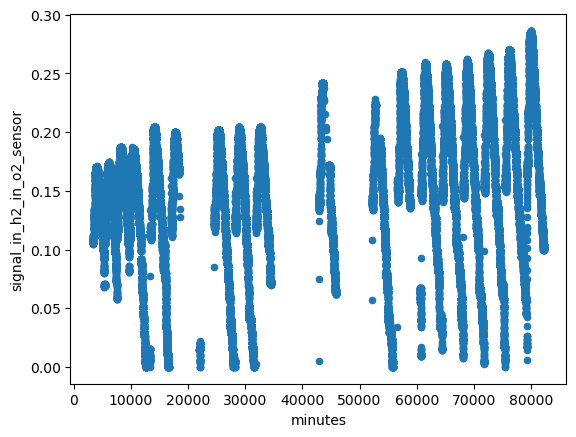

In [24]:
# time range selection

time_period = 'minutes'



df_time = df_copy.groupby(time_period).mean().reset_index()

df_time =df_time.loc[df_time['hours'] > 55]

df_time =df_time.loc[df_time['current_density'] > 0]


df_time =df_time.loc[df_time['signal_in_h2_in_o2_sensor'] > 0]

df_time.reset_index().plot(kind='scatter', x =time_period, y='signal_in_h2_in_o2_sensor')

print(len(df_time))





df_time.reset_index(inplace=True)
# df_time = df_time.drop('index',axis=1)
df_time = df_time.drop(['minutes','hours', 'days', 'weeks'],axis=1)




# df_time = df_time.rename_axis('minutes')
df_time = df_time.rename(columns={'index' : 'ds', 'signal_in_h2_in_o2_sensor':'y'})


df_time
df_time['ds'] = pd.to_datetime('2024-05-16 00:00:00') + pd.to_timedelta(df_time['ds'], unit='m')



df_time = df_time[['ds', 'y']]

data_set_base = df_time

df_time = df_time[['ds', 'y']]

df_time = df_time[df_time['ds'] > '2024-06-20 16:57:00']



In [185]:
# Best Parameters: {'changepoint_prior_scale': 0.05, 'daily_seasonality': False, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 25, 'weekly_seasonality': True, 'yearly_seasonality': False}
# Best RMSE: 0.05696205011675707

In [39]:
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
import pandas as pd
import numpy as np




# Define split ratios
train_split = 0.7  # 70% for training
valid_split = 0.15 # 15% for validation
test_split = 0.15  # 15% for testing

# Calculate split indices
train_idx = int(len(df_time) * train_split)
valid_idx = int(len(df_time) * (train_split + valid_split))

# Split data
train_df = df_time[:train_idx]
valid_df = df_time[train_idx:valid_idx]
test_df = df_time[valid_idx:]




def objective(params):
    changepoint_prior_scale, holidays_prior_scale, seasonality_prior_scale, yearly_seasonality, weekly_seasonality, daily_seasonality, two_day_cycle_period, two_day_cycle_fourier_order, three_day_cycle_period, three_day_cycle_fourier_order = params

    try:
        model = Prophet(
            changepoint_prior_scale=changepoint_prior_scale,
            holidays_prior_scale=holidays_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale,
            yearly_seasonality=yearly_seasonality,
            weekly_seasonality=weekly_seasonality,
            daily_seasonality=daily_seasonality
        )


        model.add_seasonality(
            name='custom_seasonality', 
            period=two_day_cycle_period, 
            fourier_order=two_day_cycle_fourier_order
        )


        model.add_seasonality(
        name='custom_seasonality_2', 
        period=three_day_cycle_period, 
        fourier_order=three_day_cycle_fourier_order
        )


        model.fit(train_df)

        # future = model.predict(pd.DataFrame(df_eval['ds']))
        forecast = model.predict(pd.DataFrame(valid_df['ds']))
        
        # Extract and compute RMSE
        residuals = valid_df['y'].values - forecast['yhat'][-len(valid_df):].values
        rmse = np.sqrt(np.mean(residuals ** 2))

        print("Current parameters:", params)
        percentage_rmse = (rmse / valid_df['y'].mean()) * 100
        print(f"Percentage RMSE: {percentage_rmse}%")

        
        return rmse

    except Exception as e:
        print("Error:", e)
        return float("inf")

# Define search space
search_space = [
    Real(0.0001, 0.005, name='changepoint_prior_scale'),
    Real(0.01, 30, name='holidays_prior_scale'),
    Real(0.01, 30, name='seasonality_prior_scale'),
    Categorical([False, False], name='yearly_seasonality'),
    Categorical([False, True], name='weekly_seasonality'),
    Categorical([False, False], name='daily_seasonality'),
    Real(1000, 4000, name='two_day_cycle_period'),  
    Integer(1, 35, name='two_day_cycle_fourier_order'),
    Real(1000, 4000, name='three_day_cycle_period'),  
    Integer(1, 35, name='three_day_cycle_fourier_order')
]

# Perform Bayesian optimization
result = gp_minimize(objective, search_space, n_calls=50, random_state=0)

print(f"Best parameters: {result.x}")
print(f"Lowest RMSE: {result.fun}")

16:44:09 - cmdstanpy - INFO - Chain [1] start processing
16:44:11 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.00300493862930259, 25.329529799944716, 25.739789072506483, False, True, False, 1892.603819633417, 3, 1817.9688837403396, 17]
Percentage RMSE: 55.772808695144086%


16:44:18 - cmdstanpy - INFO - Chain [1] start processing
16:44:24 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.004079626770999918, 14.404515399527972, 11.789616035063887, False, False, False, 2104.724619521644, 34, 1421.0523412379355, 31]
Percentage RMSE: 61.60644958686083%


16:44:30 - cmdstanpy - INFO - Chain [1] start processing
16:44:33 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0024206794218411816, 24.029313451869537, 15.619119611740635, False, True, False, 2612.119688347032, 27, 1317.7228215633766, 17]
Percentage RMSE: 55.465135106894245%


16:44:38 - cmdstanpy - INFO - Chain [1] start processing
16:44:39 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.001013028482301124, 22.110176132097457, 6.504345129186913, False, False, False, 1666.9641647547633, 14, 3707.7954265882145, 16]
Percentage RMSE: 42.919467164810584%


16:44:46 - cmdstanpy - INFO - Chain [1] start processing
16:44:48 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.003104010943632249, 27.071434009387794, 2.9874177072656267, False, True, False, 2074.4565009085754, 27, 2823.4920061464036, 12]
Percentage RMSE: 55.725750889785516%


16:44:54 - cmdstanpy - INFO - Chain [1] start processing
16:44:56 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0002882845897164002, 19.03187899814048, 28.768888566049373, False, True, False, 2745.5509883156033, 15, 2424.092506865239, 22]
Percentage RMSE: 53.99254064597775%


16:45:04 - cmdstanpy - INFO - Chain [1] start processing
16:45:07 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0017562373127105698, 20.245822144548036, 9.52288024465819, False, True, False, 1040.7149068363294, 22, 3020.9788925073685, 34]
Percentage RMSE: 55.5232175487085%


16:45:13 - cmdstanpy - INFO - Chain [1] start processing
16:45:17 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.004403148009601168, 15.293635057829807, 1.6808836641111735, False, False, False, 3938.760186438186, 13, 2442.680592508489, 24]
Percentage RMSE: 57.050698591070045%


16:45:26 - cmdstanpy - INFO - Chain [1] start processing
16:45:49 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.004414331857337719, 27.547881636200728, 6.512495907450012, False, True, False, 3750.168862058383, 32, 1249.337477891807, 10]
Percentage RMSE: 135.2109301231208%


16:45:54 - cmdstanpy - INFO - Chain [1] start processing
16:45:55 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.00014584785379700982, 25.271838969235258, 19.41875246422479, False, False, False, 2658.4644396627145, 7, 2109.42427824502, 6]
Percentage RMSE: 36.864405356799075%


16:46:04 - cmdstanpy - INFO - Chain [1] start processing
16:46:06 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 26.227703260802635, 0.01, False, False, False, 2181.293039387639, 35, 4000.0, 1]
Percentage RMSE: 48.23312963056618%


16:46:12 - cmdstanpy - INFO - Chain [1] start processing
16:46:15 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0021314464029887985, 9.877668513877241, 23.315085962858458, False, False, False, 2968.0559786111626, 14, 1000.0, 14]
Percentage RMSE: 43.016493226590036%


16:46:19 - cmdstanpy - INFO - Chain [1] start processing
16:46:21 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0003276119218079349, 22.31997784006724, 30.0, False, False, False, 3734.8701097743897, 1, 1000.0, 17]
Percentage RMSE: 40.9966426623434%


16:46:27 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0015926268258955147, 0.01, 30.0, False, False, False, 3605.720405647565, 1, 1000.0, 35]
Percentage RMSE: 92.96253860225909%


16:46:39 - cmdstanpy - INFO - Chain [1] start processing
16:46:41 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.000809779418672753, 28.416718851386452, 20.943615300981737, False, True, False, 3789.3063699723857, 6, 1000.0, 30]
Percentage RMSE: 48.05888353285215%


16:46:48 - cmdstanpy - INFO - Chain [1] start processing
16:46:54 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.005, 4.241078976372158, 10.825170139759425, False, False, False, 1961.2938981970458, 7, 4000.0, 26]
Percentage RMSE: 58.64404083943883%


16:47:02 - cmdstanpy - INFO - Chain [1] start processing
16:47:06 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 25.885853455695145, 29.564699540247883, False, True, False, 1000.0, 16, 1000.0, 18]
Percentage RMSE: 46.530541113631685%


16:47:10 - cmdstanpy - INFO - Chain [1] start processing
16:47:12 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.002123759205648642, 30.0, 25.889057757754113, False, False, False, 2023.3939445333317, 1, 1885.518544085705, 6]
Percentage RMSE: 43.0025268891776%


16:47:18 - cmdstanpy - INFO - Chain [1] start processing
16:47:22 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.001526887867253995, 12.374429304810118, 20.732172375787066, False, False, False, 1689.25032102213, 1, 2075.9245466990233, 21]
Percentage RMSE: 42.920418566687005%


16:47:33 - cmdstanpy - INFO - Chain [1] start processing
16:47:38 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 8.19318401060589, 8.499186342781503, False, False, False, 2090.911120562109, 35, 1086.9238563318138, 22]
Percentage RMSE: 47.065915301595304%


16:47:46 - cmdstanpy - INFO - Chain [1] start processing
16:47:51 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.005, 0.01, 0.01, False, False, False, 4000.0, 35, 1000.0, 1]
Percentage RMSE: 60.78494869654849%


16:47:55 - cmdstanpy - INFO - Chain [1] start processing
16:47:57 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0009281800853361081, 8.511176124362482, 27.668881106737924, False, False, False, 2176.9679391942514, 3, 1000.0, 6]
Percentage RMSE: 42.7691871098626%


16:48:03 - cmdstanpy - INFO - Chain [1] start processing
16:48:04 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 4.599844408310706, 9.668659529682243, False, False, False, 1056.6236664647113, 8, 1000.0, 9]
Percentage RMSE: 37.92592771349101%


16:48:08 - cmdstanpy - INFO - Chain [1] start processing
16:48:09 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 30.0, 7.902132527088221, False, True, False, 1000.0, 4, 1000.0, 1]
Percentage RMSE: 40.37075831801456%


16:48:12 - cmdstanpy - INFO - Chain [1] start processing
16:48:13 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0013860684254974392, 27.778877962261614, 27.627943639048905, False, True, False, 3078.902285721378, 1, 1571.1684746792762, 1]
Percentage RMSE: 47.80515464996714%


16:48:20 - cmdstanpy - INFO - Chain [1] start processing
16:48:24 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.00334137739764328, 6.531509679313812, 26.678680574406, False, False, False, 3774.49471581043, 23, 3988.446610318886, 1]
Percentage RMSE: 45.14479445203036%


16:48:29 - cmdstanpy - INFO - Chain [1] start processing
16:48:30 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 22.937318687471922, 30.0, False, False, False, 3691.1458192261734, 11, 3109.046820266376, 9]
Percentage RMSE: 36.996234067921925%


16:48:38 - cmdstanpy - INFO - Chain [1] start processing
16:48:40 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 0.01, 21.640838162496422, False, True, False, 4000.0, 35, 4000.0, 8]
Percentage RMSE: 44.334428208134206%


16:48:43 - cmdstanpy - INFO - Chain [1] start processing
16:48:44 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0013272763150516801, 15.535053128549826, 27.95180081736533, False, False, False, 3940.39924788776, 1, 4000.0, 1]
Percentage RMSE: 42.44730649595127%


16:48:47 - cmdstanpy - INFO - Chain [1] start processing
16:48:49 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0029410779158520867, 12.343606091614108, 9.900758169524394, False, False, False, 4000.0, 1, 4000.0, 1]
Percentage RMSE: 45.07404019116455%


16:48:52 - cmdstanpy - INFO - Chain [1] start processing
16:48:53 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 24.528197021525482, 30.0, False, False, False, 4000.0, 1, 4000.0, 1]
Percentage RMSE: 36.28532731327907%


16:48:58 - cmdstanpy - INFO - Chain [1] start processing
16:49:01 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.003888245611315244, 0.01, 7.512638425595302, False, True, False, 2901.8357294320826, 1, 1948.8296491002416, 25]
Percentage RMSE: 57.10283583518506%


16:49:05 - cmdstanpy - INFO - Chain [1] start processing
16:49:07 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0024551760799160654, 0.01, 29.535699955561586, False, False, False, 3163.2982238853447, 1, 2001.2485526670132, 6]
Percentage RMSE: 43.17901579507054%


16:49:10 - cmdstanpy - INFO - Chain [1] start processing
16:49:10 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 12.403328045451962, 28.50669031874374, False, False, False, 2735.8874277428404, 1, 2046.9637238386279, 1]
Percentage RMSE: 36.285630173051814%


16:49:17 - cmdstanpy - INFO - Chain [1] start processing
16:49:23 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0036308232242210844, 11.472651378822965, 0.01, False, True, False, 1944.397422822393, 1, 3360.934718093016, 35]
Percentage RMSE: 50.74362472449431%


16:49:31 - cmdstanpy - INFO - Chain [1] start processing
16:49:33 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 18.32028590809821, 0.01, False, True, False, 2295.85818342922, 1, 1602.8060899822667, 35]
Percentage RMSE: 48.37942235124081%


16:49:38 - cmdstanpy - INFO - Chain [1] start processing
16:49:39 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 23.305846051566306, 30.0, False, False, False, 1000.0, 1, 1000.0, 6]
Percentage RMSE: 37.01443540189555%


16:49:44 - cmdstanpy - INFO - Chain [1] start processing
16:49:45 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 29.582601663006113, 30.0, False, False, False, 2244.614723480352, 1, 3862.2116602718497, 6]
Percentage RMSE: 36.86251517630695%


16:49:55 - cmdstanpy - INFO - Chain [1] start processing
16:50:08 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.005, 0.04535978610511205, 30.0, False, True, False, 1070.9435600578631, 1, 2966.8126783184753, 35]
Percentage RMSE: 55.953677634710765%


16:50:18 - cmdstanpy - INFO - Chain [1] start processing
16:50:23 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.002164734853341662, 10.75388049647752, 30.0, False, False, False, 3103.604693135882, 35, 1097.7327412356651, 1]
Percentage RMSE: 43.10824388898588%


16:50:27 - cmdstanpy - INFO - Chain [1] start processing
16:50:28 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0020052191573552715, 7.840888167594174, 30.0, False, False, False, 1984.339973301991, 1, 3940.693229037877, 1]
Percentage RMSE: 43.07744269844388%


16:50:35 - cmdstanpy - INFO - Chain [1] start processing
16:50:40 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0021903534685859243, 23.43557682994828, 30.0, False, True, False, 3574.668072103587, 35, 4000.0, 1]
Percentage RMSE: 48.29064760963403%


16:50:43 - cmdstanpy - INFO - Chain [1] start processing
16:50:44 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 27.830021604737585, 30.0, False, False, False, 4000.0, 1, 4000.0, 5]
Percentage RMSE: 36.71076565313079%


16:50:48 - cmdstanpy - INFO - Chain [1] start processing
16:50:48 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 20.880515232333995, 30.0, False, False, False, 2751.1959010849587, 1, 2063.69204943997, 5]
Percentage RMSE: 36.69609546884035%


16:50:52 - cmdstanpy - INFO - Chain [1] start processing
16:50:53 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 0.49523085641928605, 30.0, False, False, False, 1000.0, 1, 4000.0, 6]
Percentage RMSE: 36.86318346858513%


16:50:56 - cmdstanpy - INFO - Chain [1] start processing
16:50:57 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 4.311463649569649, 30.0, False, False, False, 1874.503241468659, 1, 4000.0, 6]
Percentage RMSE: 36.85565287319207%


16:51:00 - cmdstanpy - INFO - Chain [1] start processing
16:51:01 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 22.39980810131751, 30.0, False, False, False, 3450.769590771074, 1, 4000.0, 6]
Percentage RMSE: 36.854950437970246%


16:51:05 - cmdstanpy - INFO - Chain [1] start processing
16:51:06 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0001, 29.85824827582672, 0.01, False, True, False, 1000.0, 1, 2187.2167056274075, 9]
Percentage RMSE: 40.560662341158356%


16:51:14 - cmdstanpy - INFO - Chain [1] start processing
16:51:17 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.0015807712594558259, 26.78316513591847, 20.744627958392943, False, False, False, 2898.00326921354, 35, 3772.1276951998707, 16]
Percentage RMSE: 43.01955412054587%


16:51:26 - cmdstanpy - INFO - Chain [1] start processing
16:51:32 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: [0.003316687937391241, 30.0, 0.01, False, False, False, 1000.0, 35, 4000.0, 13]
Percentage RMSE: 48.89918242319438%
Best parameters: [0.0001, 24.528197021525482, 30.0, False, False, False, 4000.0, 1, 4000.0, 1]
Lowest RMSE: 0.06471027120872867


In [ ]:

# Current parameters: [0.0010501500422376551, 30.0, 0.01, False, True, False]
# Percentage RMSE: 36.83629033591356%

16:58:23 - cmdstanpy - INFO - Chain [1] start processing
16:58:24 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.06778172086311675
Percentage RMSE: 39.312867186437536%


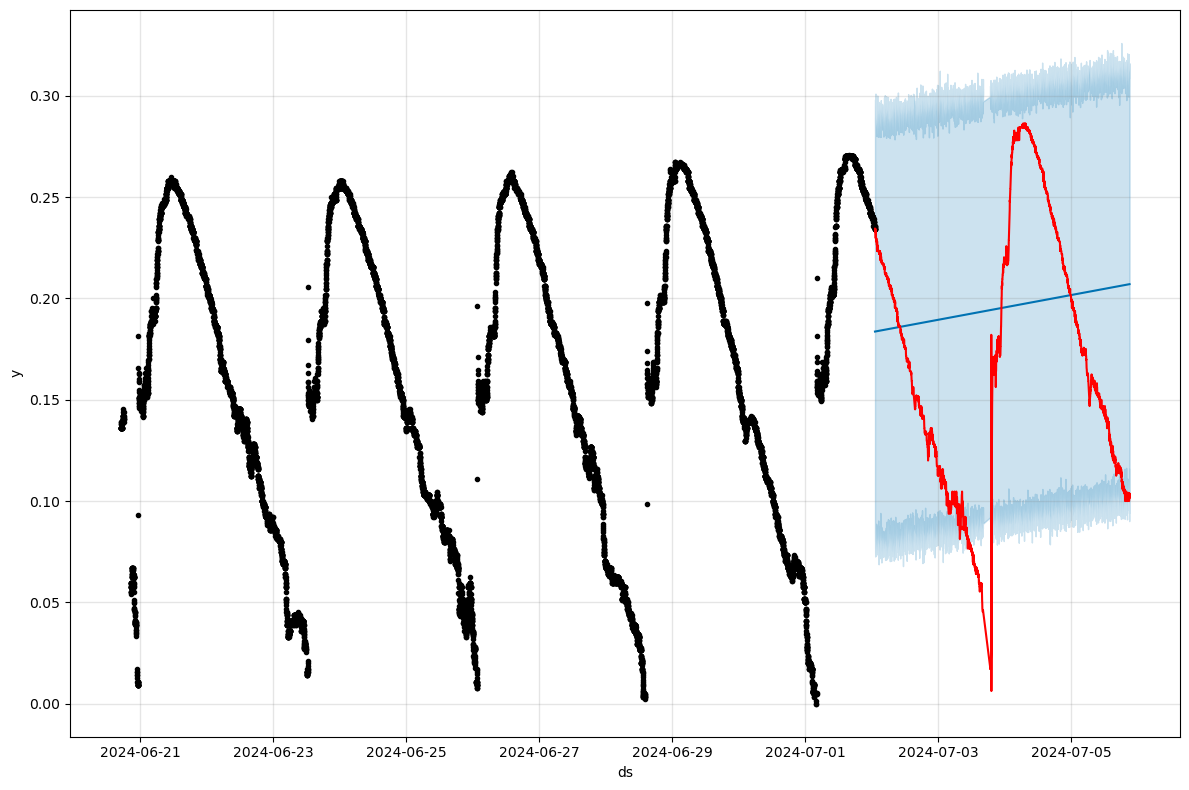

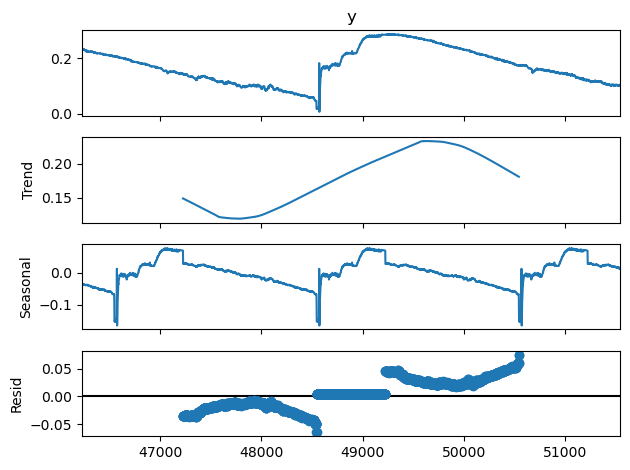

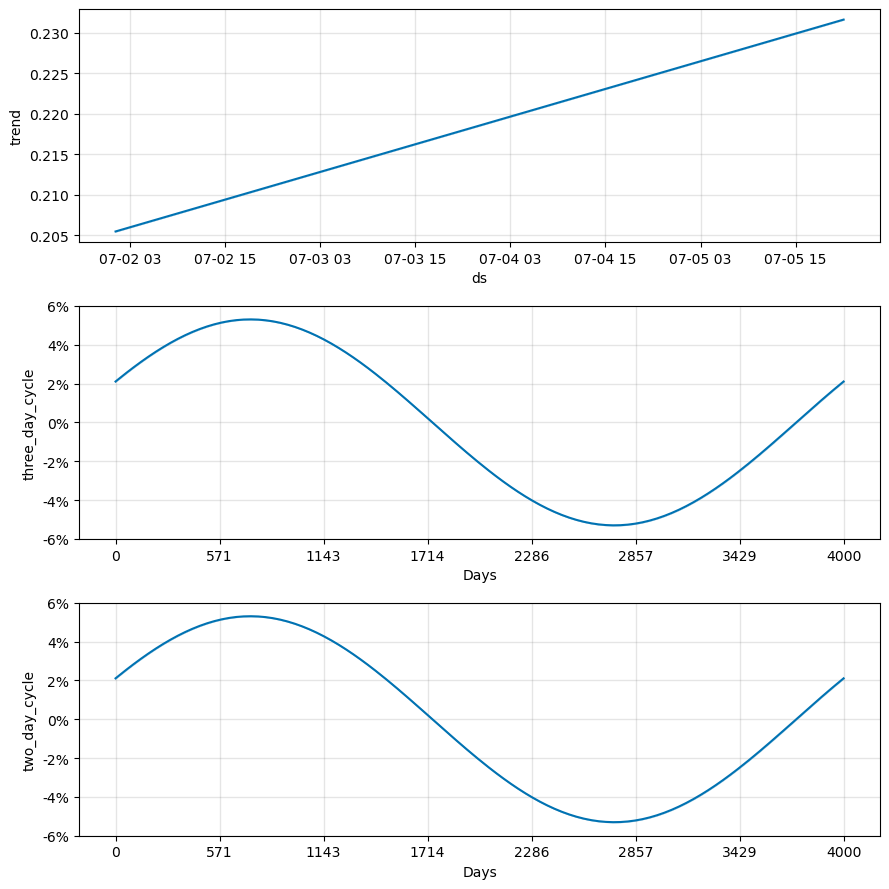

In [44]:




split = 0.75

n = int(len(df_time)*split)

df_t = df_time[:n]
df_eval = df_time[n:]
df_t




model = Prophet(changepoint_prior_scale= 0.0001,
                holidays_prior_scale= 24.698535978015747, 
                seasonality_prior_scale= 30.0,
                  yearly_seasonality=False,
                    weekly_seasonality=False,
                    daily_seasonality=False,
                seasonality_mode='multiplicative'

)



model.add_seasonality(name='two_day_cycle', period=4000, fourier_order=1)
model.add_seasonality(name='three_day_cycle', period=4000, fourier_order=1)


model.fit(df_t)

# future = model.predict(pd.DataFrame(df_eval['ds']))
forecast = model.predict(pd.DataFrame(df_eval['ds']))

# Extract and compute RMSE
residuals = df_eval['y'].values - forecast['yhat'][-len(df_eval):].values
rmse = np.sqrt(np.mean(residuals ** 2))
print(f"RMSE: {rmse}")

percentage_rmse = (rmse / df_eval['y'].mean()) * 100
print(f"Percentage RMSE: {percentage_rmse}%")





fig = model.plot(forecast, figsize=(12,8))
ax = fig.gca()
ax.plot(df_eval['ds'], df_eval['y'], color='r');




from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
# Decompose the time series
decomposition = seasonal_decompose(df_eval['y'], model='additive', period=2000)

# Plot the decomposition results
decomposition.plot()
plt.show()


fig2 = model.plot_components(forecast)
plt.show()



In [231]:
# Best parameters: [0.00028504517037275263, 26.672884325311287, 27.495020917919785, False, True, False, 2000.0, 35]
# Lowest RMSE: 0.06352520031260397

08:43:35 - cmdstanpy - INFO - Chain [1] start processing
08:43:46 - cmdstanpy - INFO - Chain [1] done processing


Current parameters: {'changepoint_prior_scale': 1, 'daily_seasonality': True, 'holidays_prior_scale': 30, 'seasonality_prior_scale': 25, 'weekly_seasonality': True, 'yearly_seasonality': True}
Percentage RMSE: 50.94283034462175%


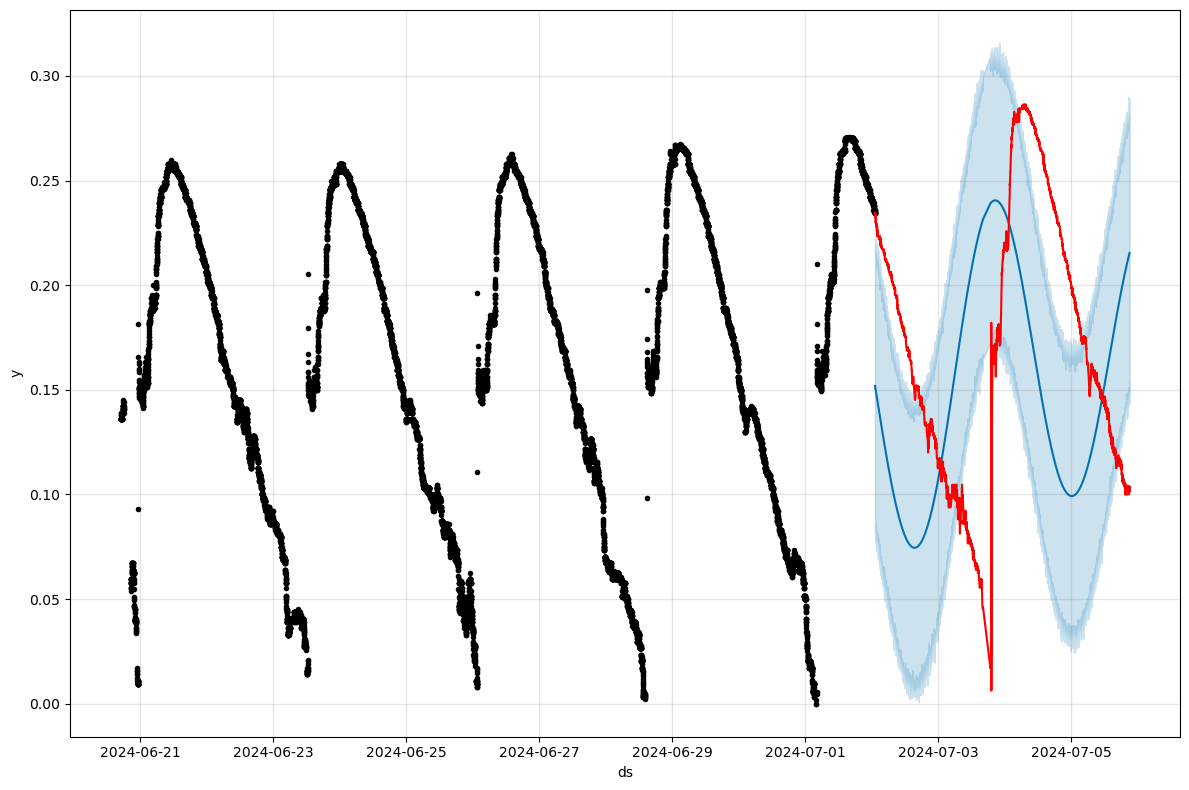

In [233]:

#  Best parameters: [0.00028504517037275263, 26.672884325311287, 27.495020917919785, False, True, False, 2000.0, 35]
# Lowest RMSE: 0.06352520031260397


split = 0.75

n = int(len(df_time)*split)

df_t = df_time[:n]
df_eval = df_time[n:]
df_t




model = Prophet(changepoint_prior_scale= 0.00028504517037275263,
                holidays_prior_scale= 26.672884325311287, 
                seasonality_prior_scale= 27.495020917919785,
                  yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=False
)



model.add_seasonality(name='two_day_cycle', period=2000, fourier_order=35)

model.fit(df_t)

# future = model.predict(pd.DataFrame(df_eval['ds']))
forecast = model.predict(pd.DataFrame(df_eval['ds']))

# Extract and compute RMSE
residuals = df_eval['y'].values - forecast['yhat'][-len(df_eval):].values
rmse = np.sqrt(np.mean(residuals ** 2))

print("Current parameters:", params)
percentage_rmse = (rmse / df_eval['y'].mean()) * 100
print(f"Percentage RMSE: {percentage_rmse}%")





fig = model.plot(forecast, figsize=(12,8))
ax = fig.gca()
ax.plot(df_eval['ds'], df_eval['y'], color='r');





